In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import *  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:

    
df=pd.read_csv('framingham.csv')
df.drop('education',axis=1,inplace=True)
df.dropna(axis=0,inplace=True)


dataX=df.iloc[:,:-1]
datay=df.iloc[:,-1]


X_train, X_test, y_train, y_test =train_test_split(dataX,datay,test_size=0.3,random_state=0)



### Data set

In [3]:

df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


0.6281241778479347


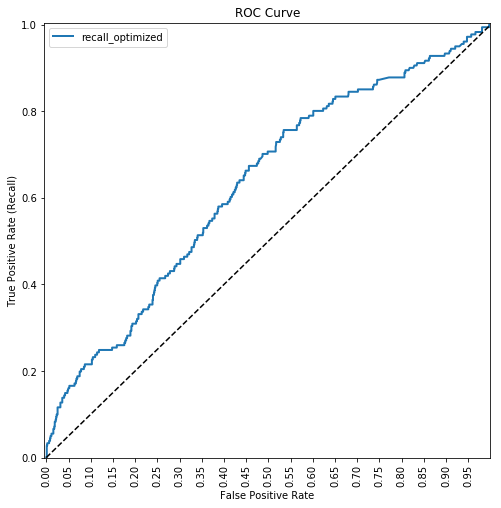

In [30]:
def plot_confusion_matrix(y, pred, labels, classes, normalize=False, cmap=plt.cm.Blues):
    """
    Plots the confusion matrix.
    Args:
        y: Data Labels
        pred: Predicted outputs
        labels: A list of label values to calculate confusion matrix
        classes: A list of containing unique class names for plotting
        normalize:Wheter to plot data with int or percentage values. Default is int.
        cmap: Color map pf the plot
    
    """
    cm = confusion_matrix(y, pred, labels=labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    return y_pred_adj
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [5]:
THRESHOLD=0.5
def score_fn(X_train,y_train,X_test,y_test,threshold):
    lr=LogisticRegression().fit(X_train,y_train)
    y_pred=np.where(lr.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    # using cross validation across training data
    train=cross_val_score(lr,X=X_train,y=y_train,cv=4)
    print('training set accuracy : ',train.mean())
    # using accuracy over test set 
    test=cross_val_score(lr,X=X_test,y=y_test,cv=4)
    print('test set accuracy : ',test.mean())
    print('coefficients corresponding to features')
    print(pd.DataFrame(np.array(lr.coef_),columns=X_train.columns))
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, labels=[1, 0], classes=['target=1','target=0'])
    
    

training set accuracy :  0.8518085606944901
test set accuracy :  0.8410428429510959
coefficients corresponding to features
       male       age  currentSmoker  cigsPerDay   BPMeds  prevalentStroke  \
0  0.415071  0.044982      -0.093784     0.02199 -0.07089         0.200768   

   prevalentHyp  diabetes   totChol     sysBP     diaBP       BMI  heartRate  \
0      0.550871  0.561607  0.001572  0.017132 -0.019275 -0.003067  -0.015561   

    glucose  
0  0.003616  
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       945
           1       0.75      0.07      0.12       181

    accuracy                           0.85      1126
   macro avg       0.80      0.53      0.52      1126
weighted avg       0.83      0.85      0.79      1126



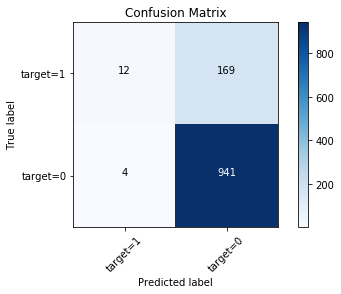

In [6]:

score_fn(X_train,y_train,X_test,y_test,0.25)

### Logistic regression 

In [7]:

from sklearn.model_selection import KFold
def cv_validation(fitted_model,datasetX,datasety,n_folds,THRESHOLD):  
    # prepare cross validation
    kfold = KFold(n_folds, True, 1)
    # enumerate splits
    scores=[]
    X_train=datasetX
    y_train=datasety
    for train, test in kfold.split(X_train,y_train):
        #print('train: %s, test: %s' % (X_train.iloc[train,:].shape, X_train.iloc[test,:].shape))
        X_train_sub,X_test_sub,y_train_sub,y_test_sub=X_train.iloc[train,:], X_train.iloc[test,:],y_train.iloc[train],y_train.iloc[test]
        #print(X_train_sub.shape,X_test_sub.shape,y_train_sub.shape,y_test_sub.shape)
        fitted_model.fit(X_train_sub,y_train_sub)
        #if fitted_model== 'lr':
        y_pred=np.where(fitted_model.predict_proba(X_test_sub)[:,1] > THRESHOLD, 1, 0)
        #else :
        #y_pred=fitted_model.predict(X_test_sub)
        scores.append(accuracy_score(y_test_sub,y_pred))
        #print(metrics.accuracy_score(y_test_sub,y_pred))
    return np.mean(scores)


### Adjust the threshold and examine different values of recall and precision 

In [8]:
lr=LogisticRegression().fit(X_train,y_train)
print(X_test.shape)
pred_proba_df = pd.DataFrame(lr.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For threshold = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy =accuracy_score(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                                          y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))
    print('Our cv testing accuracy is {}'.format(cv_validation(lr,dataX,datay,4,i)))
    print(classification_report(y_test.as_matrix().reshape(y_test.as_matrix().size,1), y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1)))
    
    print(confusion_matrix(y_test.as_matrix().reshape(y_test.as_matrix().size,1),
                           y_test_pred.iloc[:,1].as_matrix().reshape(y_test_pred.iloc[:,1].as_matrix().size,1),labels=[0,1]))

(1126, 14)

******** For threshold = 0.05 ******
Our testing accuracy is 0.25133214920071045
Our cv testing accuracy is 0.23486612902858783
              precision    recall  f1-score   support

           0       0.96      0.11      0.20       945
           1       0.17      0.98      0.30       181

    accuracy                           0.25      1126
   macro avg       0.57      0.55      0.25      1126
weighted avg       0.84      0.25      0.22      1126

[[106 839]
 [  4 177]]

******** For threshold = 0.1 ******
Our testing accuracy is 0.5053285968028419
Our cv testing accuracy is 0.49480234518822264
              precision    recall  f1-score   support

           0       0.93      0.45      0.60       945
           1       0.22      0.82      0.35       181

    accuracy                           0.51      1126
   macro avg       0.57      0.63      0.47      1126
weighted avg       0.81      0.51      0.56      1126

[[421 524]
 [ 33 148]]

******** For threshold = 0.15 **

Our cv testing accuracy is 0.8475107121808249
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       945
           1       0.00      0.00      0.00       181

    accuracy                           0.84      1126
   macro avg       0.42      0.50      0.46      1126
weighted avg       0.70      0.84      0.77      1126

[[945   0]
 [181   0]]


(0, 1)

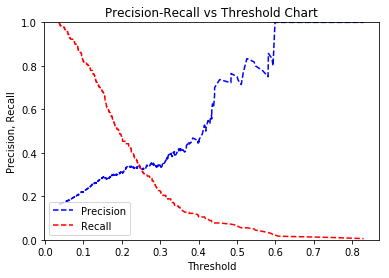

In [9]:
### Predict test_y values and probabilities based on fitted logistic 
#regression model
lr=LogisticRegression().fit(X_train,y_train)
pred_y=lr.predict(X_test) 

probs_y=lr.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first 
  #column of array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
from sklearn import metrics
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### Applying oversampling on minority class to optimize for recall score

In [ ]:
sm = SMOTE(random_state=12, sampling_strategy = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
x_train_res=pd.DataFrame(data=x_train_res)
y_train_res=pd.DataFrame(data= y_train_res)
x_train_res.shape ,  y_train_res.shape , X_train.shape , y_train.shape


In [ ]:
lr_cv=LogisticRegression()


lr=LogisticRegression().fit(x_train_res, y_train_res)
train_org=cross_val_score(lr_cv,X=x_train_res,y=y_train_res,cv=4)
THRESHOLD=0.5
print(X_test.shape)
y_pred=np.where(lr.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print('unoptimized training accuracy : ', train_org.mean())
# using cross validation across training data
train=cv_validation(lr_cv,x_train_res, y_train_res,6,THRESHOLD=THRESHOLD)
print('training set accuracy cv : ',train)
# using accuracy over test set 
test=cv_validation(lr_cv,X_test,y_test,6,THRESHOLD=THRESHOLD)
print('test set accuracy  cv : ',test)

total=cv_validation(lr_cv,dataX,datay,6,THRESHOLD=THRESHOLD)
print('cv accuracy over all dataset : ', total)
print('coefficients corresponding to features')
print(pd.DataFrame(np.array(lr.coef_),columns=X_train.columns))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, labels=[0, 1], classes=['target=0','target=1'])
print(confusion_matrix(y_test,y_pred,labels=[0, 1]))
tn, fp, fn, tp=confusion_matrix(y_test,y_pred,labels=[0, 1]).ravel()
print('tn',tn)
print('fp',fp)
print('fn',fn)
print('tp',tp)

In [ ]:
from sklearn.ensemble import  GradientBoostingClassifier , AdaBoostClassifier ,RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

### Random Forest Classifier 

In [ ]:
clf_cv=RandomForestClassifier()
clf = RandomForestClassifier().fit(x_train_res, y_train_res)
train_org=cross_val_score(clf,X=x_train_res,y=y_train_res,cv=4)
THRESHOLD=0.2
print(X_test.shape)
y_pred=np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print('unoptimized training accuracy : ', train_org.mean())
# using cross validation across training data
train=cv_validation(clf_cv,x_train_res, y_train_res,4,THRESHOLD=THRESHOLD)
print('training set accuracy cv : ',train)
# using accuracy over test set 
test=cv_validation(clf_cv,X_test,y_test,4,THRESHOLD=THRESHOLD)
print('test set accuracy  cv : ',test)


print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, labels=[0, 1], classes=['target=0','target=1'])
print(confusion_matrix(y_test,y_pred,labels=[0, 1]))
tn, fp, fn, tp=confusion_matrix(y_test,y_pred,labels=[0, 1]).ravel()
print('tn',tn)
print('fp',fp)
print('fn',fn)
print('tp',tp)

### Gradient boosting 

(1126, 14)
unoptimized training accuracy :  0.868209039439347
training set accuracy cv :  0.7184422560429723
test set accuracy  cv :  0.6970987607581839
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       945
           1       0.19      0.57      0.29       181

    accuracy                           0.55      1126
   macro avg       0.53      0.56      0.48      1126
weighted avg       0.76      0.55      0.61      1126

[[519 426]
 [ 78 103]]
tn 519
fp 426
fn 78
tp 103


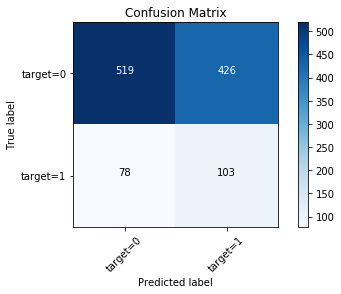

In [15]:

gb_cv_0=GradientBoostingClassifier(loss= 'deviance', max_depth= 25, learning_rate= 0.2, n_estimators=100, max_features= 14)
gb_cv= CalibratedClassifierCV(gb_cv_0) 

gb=CalibratedClassifierCV(gb_cv_0).fit(x_train_res, y_train_res)

train_org=cross_val_score(gb,X=x_train_res,y=y_train_res,cv=4)
THRESHOLD=0.17
print(X_test.shape)
y_pred=np.where(gb.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print('unoptimized training accuracy : ', train_org.mean())
# using cross validation across training data
train=cv_validation(gb_cv,x_train_res, y_train_res,4,THRESHOLD=THRESHOLD)
print('training set accuracy cv : ',train)
# using accuracy over test set 
test=cv_validation(gb_cv,X_test,y_test,4,THRESHOLD=THRESHOLD)
print('test set accuracy  cv : ',test)


print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, labels=[0, 1], classes=['target=0','target=1'])
print(confusion_matrix(y_test,y_pred,labels=[0, 1]))
tn, fp, fn, tp=confusion_matrix(y_test,y_pred,labels=[0, 1]).ravel()
print('tn',tn)
print('fp',fp)
print('fn',fn)
print('tp',tp)

### Ada Boost classifier 

(1126, 14)
unoptimized training accuracy :  0.845713891148898
training set accuracy cv :  0.8430481308237741
test set accuracy  cv :  0.8144229070442442
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       945
           1       0.30      0.05      0.09       181

    accuracy                           0.83      1126
   macro avg       0.57      0.51      0.50      1126
weighted avg       0.76      0.83      0.77      1126

[[924  21]
 [172   9]]
tn 924
fp 21
fn 172
tp 9


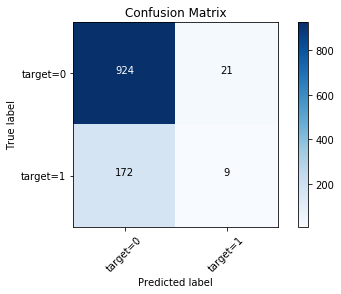

In [21]:
ab_cv=AdaBoostClassifier()
ab=AdaBoostClassifier().fit(X_train,y_train)
 

train_org=cross_val_score(ab,X=X_train,y=y_train,cv=4)
THRESHOLD=0.5
print(X_test.shape)
y_pred=np.where(ab.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

print('unoptimized training accuracy : ', train_org.mean())
# using cross validation across training data
train=cv_validation(ab_cv,X_train,y_train,4,THRESHOLD=THRESHOLD)
print('training set accuracy cv : ',train)
# using accuracy over test set 
test=cv_validation(ab_cv,X_test,y_test,4,THRESHOLD=THRESHOLD)
print('test set accuracy  cv : ',test)


print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, labels=[0, 1], classes=['target=0','target=1'])
print(confusion_matrix(y_test,y_pred,labels=[0, 1]))
tn, fp, fn, tp=confusion_matrix(y_test,y_pred,labels=[0, 1]).ravel()
print('tn',tn)
print('fp',fp)
print('fn',fn)
print('tp',tp)

### Try different approach : optimizing hyperparameters of different Algorithms on recall score using Grid search

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


clf= GradientBoostingClassifier()
#clf=CalibratedClassifierCV(clf_0)
param_grid = {
    'loss':['deviance','exponential'],
    'learning_rate' : [0.01,0.05,0.1,0.15,0.2,0.5],
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 14]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='recall_score')

y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

y_scores

Best params for recall_score
{'learning_rate': 0.5, 'loss': 'deviance', 'max_depth': 25, 'max_features': 14, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       829       116
pos       136        45


array([9.93713382e-01, 1.18631492e-04, 7.66426983e-05, ...,
       7.50843490e-04, 3.53366595e-04, 1.77458039e-04])

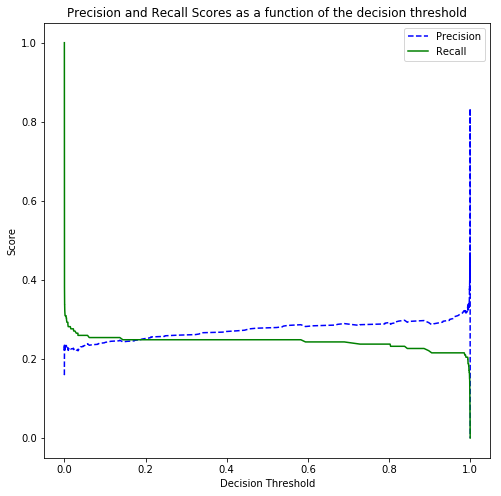

In [32]:
#precision_recall_threshold(p, r, thresholds, 0.2)
p, r, thresholds = precision_recall_curve(y_test, y_scores)
plot_precision_recall_vs_threshold(p, r, thresholds)

### Logistic regression along with oversampling of miniority class and threshold adjusting scored the best among several methods used to decrease False negatives